In [33]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

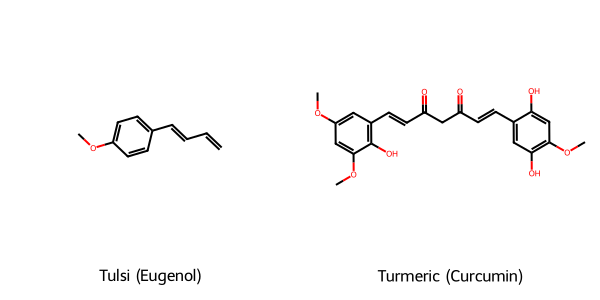

In [34]:
smiles_dict = {
    "Tulsi": "COC1=CC=C(C=C1)C=CC=C",   # Eugenol
    "Turmeric": "COC1=CC(=CC(=C1O)C=CC(=O)CC(=O)C=CC2=CC(=C(C=C2O)OC)O)OC"  # Curcumin
}

mol_tulsi = Chem.MolFromSmiles(smiles_dict["Tulsi"])
mol_turmeric = Chem.MolFromSmiles(smiles_dict["Turmeric"])

img = Draw.MolsToGridImage(
    [mol_tulsi, mol_turmeric],
    legends=["Tulsi (Eugenol)", "Turmeric (Curcumin)"],
    molsPerRow=2,
    subImgSize=(300,300)
)
display(img)

In [35]:
def get_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
    }

In [36]:
chem_features = []
labels = []

num_samples_per_herb = 1000  # Large dataset
for herb, smi in smiles_dict.items():
    for _ in range(num_samples_per_herb):
        chem_features.append(get_rdkit_descriptors(smi))
        labels.append(herb)

In [37]:
np.random.seed(42)
def simulate_sensor_data(herb_type):
    if herb_type == "Tulsi":
        base_taste = [0.8, 0.4, 0.3]
        base_smell = [0.7, 0.5, 0.2, 0.4]
        base_special = [0.6, 0.5]
    elif herb_type == "Turmeric":
        base_taste = [0.3, 0.6, 0.8]
        base_smell = [0.5, 0.7, 0.6, 0.3]
        base_special = [0.7, 0.9]
    else:  # Adulterated
        base_taste = np.random.rand(3).tolist()
        base_smell = np.random.rand(4).tolist()
        base_special = np.random.rand(2).tolist()
    taste = np.array(base_taste) + np.random.normal(0, 0.05, 3)
    smell = np.array(base_smell) + np.random.normal(0, 0.05, 4)
    special = np.array(base_special) + np.random.normal(0, 0.05, 2)
    return np.concatenate([taste, smell, special])

sensor_features = [simulate_sensor_data(herb) for herb in labels]

In [38]:
num_adulterated = 50
for _ in range(num_adulterated):
    chem_features.append(get_rdkit_descriptors(smiles_dict["Tulsi"]))
    sensor_features.append(simulate_sensor_data("Adulterated"))
    labels.append("Adulterated_Tulsi")
for _ in range(num_adulterated):
    chem_features.append(get_rdkit_descriptors(smiles_dict["Turmeric"]))
    sensor_features.append(simulate_sensor_data("Adulterated"))
    labels.append("Adulterated_Turmeric")

In [39]:
chem_df = pd.DataFrame(chem_features)
sensor_df = pd.DataFrame(sensor_features, columns=[f"T{i}" for i in range(1,4)] +
                         [f"N{i}" for i in range(1,5)] + [f"S{i}" for i in range(1,3)])
fused_df = pd.concat([chem_df, sensor_df], axis=1)
labels = np.array(labels)

print("Sample Data:\n", fused_df.head())
print("\nLabels Sample:\n", labels[:5])

Sample Data:
      MolWt    LogP  TPSA  NumHDonors  NumHAcceptors        T1        T2  \
0  160.216  2.8944  9.23           0              1  0.824836  0.393087   
1  160.216  2.8944  9.23           0              1  0.827128  0.376829   
2  160.216  2.8944  9.23           0              1  0.754599  0.329385   
3  160.216  2.8944  9.23           0              1  0.818785  0.369968   
4  160.216  2.8944  9.23           0              1  0.810443  0.302016   

         T3        N1        N2        N3        N4        S1        S2  
0  0.332384  0.776151  0.488292  0.188293  0.478961  0.638372  0.476526  
1  0.276714  0.712098  0.404336  0.113754  0.371886  0.549358  0.515712  
2  0.373282  0.688711  0.503376  0.128763  0.372781  0.605546  0.442450  
3  0.285415  0.669915  0.592614  0.199325  0.347114  0.641127  0.438958  
4  0.233591  0.709843  0.536923  0.208568  0.394218  0.584945  0.426074  

Labels Sample:
 ['Tulsi' 'Tulsi' 'Tulsi' 'Tulsi' 'Tulsi']


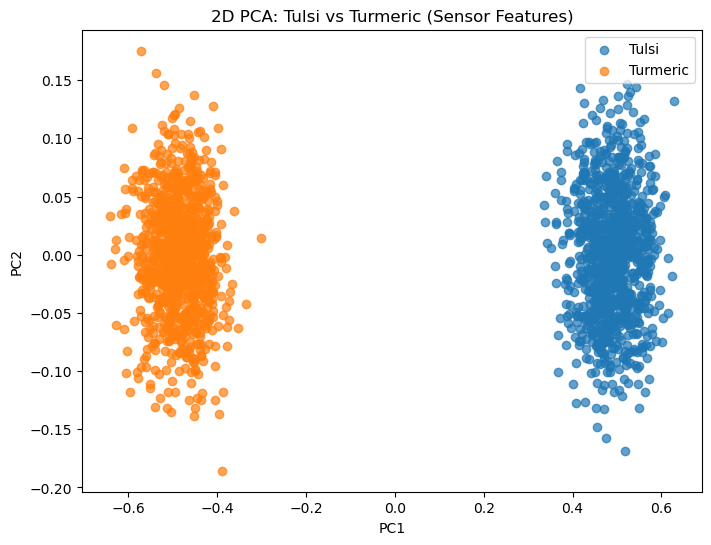

In [40]:
sensor_cols = [f"T{i}" for i in range(1,4)] + [f"N{i}" for i in range(1,5)] + [f"S{i}" for i in range(1,3)]
mask2d = (labels == "Tulsi") | (labels == "Turmeric")
X_sensor = sensor_df[mask2d]
y_sensor = labels[mask2d]

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_sensor)

plt.figure(figsize=(8,6))
for herb in ["Tulsi", "Turmeric"]:
    idx = y_sensor == herb
    plt.scatter(X_pca_2d[idx,0], X_pca_2d[idx,1], label=herb, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA: Tulsi vs Turmeric (Sensor Features)")
plt.legend()
plt.show()

In [41]:
mask3d = (labels == "Tulsi") | (labels == "Turmeric") | (labels == "Adulterated_Tulsi") | (labels == "Adulterated_Turmeric")
X_sensor_all = sensor_df[mask3d]
y_sensor_all = labels[mask3d]

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_sensor_all)

df_plot = pd.DataFrame(X_pca_3d, columns=["PC1","PC2","PC3"])
df_plot["Herb"] = y_sensor_all

fig = px.scatter_3d(df_plot, x="PC1", y="PC2", z="PC3", color="Herb",
                    title="3D PCA: Tulsi, Turmeric & Adulterated Samples",
                    symbol="Herb", opacity=0.8)
fig.show()

In [42]:
# Example thresholds (Minimum Detectable Concentrations)
thresholds = {
    "Sweet": 0.3,    # glucose w/v
    "Bitter": 0.05,  # caffeine w/v
    "Sour": 0.02,    # citric acid w/v
}

# Simulated concentration values
fused_df["Concentration"] = np.random.uniform(0, 0.5, size=len(fused_df))

# Apply threshold detection
def check_threshold(row, taste="Bitter"):
    if row["Concentration"] >= thresholds[taste]:
        return "Above Threshold → Taste perceivable"
    else:
        return "Below Threshold → Not perceivable"

fused_df["Threshold_Status"] = fused_df.apply(check_threshold, axis=1)
print(fused_df[["Concentration", "Threshold_Status"]].head())


   Concentration                     Threshold_Status
0       0.064792  Above Threshold → Taste perceivable
1       0.168509  Above Threshold → Taste perceivable
2       0.385522  Above Threshold → Taste perceivable
3       0.053307  Above Threshold → Taste perceivable
4       0.114919  Above Threshold → Taste perceivable


In [43]:
# Step 1: Add synthetic sensor values for taste markers
np.random.seed(42)

def simulate_extended_sensors(herb_type):
    if herb_type == "Tulsi":  
        # Ranges are rough approximations for demo
        ph = np.random.uniform(6.0, 7.5)            # neutral to slightly basic
        conductivity = np.random.uniform(100, 200)  # saltiness proxy (µS/cm)
        tds = np.random.uniform(150, 250)           # dissolved solids (ppm)
        bitter_marker = np.random.uniform(0.05, 0.2) # caffeine-equivalent levels
    elif herb_type == "Turmeric":
        ph = np.random.uniform(5.5, 7.0)
        conductivity = np.random.uniform(80, 150)
        tds = np.random.uniform(120, 200)
        bitter_marker = np.random.uniform(0.1, 0.3)
    else:  # Adulterated
        ph = np.random.uniform(4.0, 8.0)
        conductivity = np.random.uniform(50, 300)
        tds = np.random.uniform(50, 400)
        bitter_marker = np.random.uniform(0.0, 0.5)
    return [ph, conductivity, tds, bitter_marker]

# Generate new features
extra_sensor_features = [simulate_extended_sensors(h) for h in labels]
extra_sensor_df = pd.DataFrame(extra_sensor_features, columns=["pH","Conductivity","TDS","BitterMarker"])

# Fuse with old dataset
fused_df = pd.concat([fused_df.reset_index(drop=True), extra_sensor_df], axis=1)
print("New fused dataset:\n", fused_df.head())


New fused dataset:
      MolWt    LogP  TPSA  NumHDonors  NumHAcceptors        T1        T2  \
0  160.216  2.8944  9.23           0              1  0.824836  0.393087   
1  160.216  2.8944  9.23           0              1  0.827128  0.376829   
2  160.216  2.8944  9.23           0              1  0.754599  0.329385   
3  160.216  2.8944  9.23           0              1  0.818785  0.369968   
4  160.216  2.8944  9.23           0              1  0.810443  0.302016   

         T3        N1        N2        N3        N4        S1        S2  \
0  0.332384  0.776151  0.488292  0.188293  0.478961  0.638372  0.476526   
1  0.276714  0.712098  0.404336  0.113754  0.371886  0.549358  0.515712   
2  0.373282  0.688711  0.503376  0.128763  0.372781  0.605546  0.442450   
3  0.285415  0.669915  0.592614  0.199325  0.347114  0.641127  0.438958   
4  0.233591  0.709843  0.536923  0.208568  0.394218  0.584945  0.426074   

   Concentration                     Threshold_Status        pH  Conductivity 

In [44]:
# Step 2: Threshold logic
thresholds = {
    "Sweet": 0.3,      # e.g. glucose (% w/v)
    "Bitter": 0.05,    # caffeine (% w/v equivalent)
    "Sour": 5.0,       # pH below 5.0 = sour
    "Salt": 150        # conductivity µS/cm threshold
}

def check_threshold(row):
    status = {}
    status["Sweetness"] = "Perceivable" if row["TDS"]/100 > thresholds["Sweet"] else "Below Threshold"
    status["Bitterness"] = "Perceivable" if row["BitterMarker"] > thresholds["Bitter"] else "Below Threshold"
    status["Sourness"] = "Perceivable" if row["pH"] < thresholds["Sour"] else "Below Threshold"
    status["Saltiness"] = "Perceivable" if row["Conductivity"] > thresholds["Salt"] else "Below Threshold"
    return status

# Apply for first few samples
for i in range(5):
    print("Sample", i, check_threshold(fused_df.iloc[i]))


Sample 0 {'Sweetness': 'Perceivable', 'Bitterness': 'Perceivable', 'Sourness': 'Below Threshold', 'Saltiness': 'Perceivable'}
Sample 1 {'Sweetness': 'Perceivable', 'Bitterness': 'Perceivable', 'Sourness': 'Below Threshold', 'Saltiness': 'Below Threshold'}
Sample 2 {'Sweetness': 'Perceivable', 'Bitterness': 'Perceivable', 'Sourness': 'Below Threshold', 'Saltiness': 'Perceivable'}
Sample 3 {'Sweetness': 'Perceivable', 'Bitterness': 'Perceivable', 'Sourness': 'Below Threshold', 'Saltiness': 'Below Threshold'}
Sample 4 {'Sweetness': 'Perceivable', 'Bitterness': 'Perceivable', 'Sourness': 'Below Threshold', 'Saltiness': 'Perceivable'}


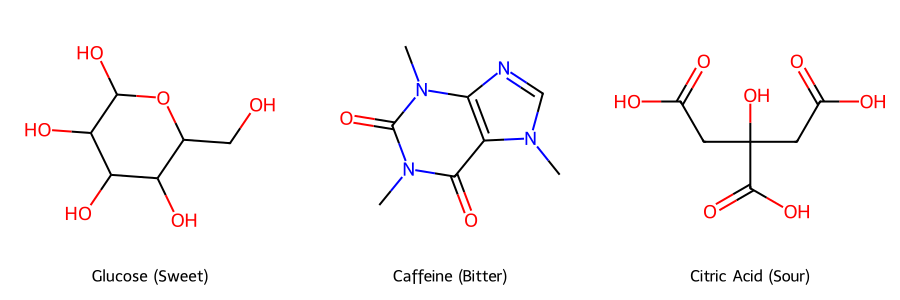

In [45]:
phytochemicals = {
    "Glucose": "C(C1C(C(C(C(O1)O)O)O)O)O",   # Sweet
    "Caffeine": "Cn1cnc2c1c(=O)n(c(=O)n2C)C", # Bitter
    "Citric Acid": "C(C(=O)O)C(CC(=O)O)(C(=O)O)O" # Sour
}

# Create molecule objects for visualization
mol_glucose = Chem.MolFromSmiles(phytochemicals["Glucose"])
mol_caffeine = Chem.MolFromSmiles(phytochemicals["Caffeine"])
mol_citric_acid = Chem.MolFromSmiles(phytochemicals["Citric Acid"])

# Create and display visualization
img = Draw.MolsToGridImage(
    [mol_glucose, mol_caffeine, mol_citric_acid],
    legends=["Glucose (Sweet)", "Caffeine (Bitter)", "Citric Acid (Sour)"],
    molsPerRow=3,
    subImgSize=(300,300)
)
display(img)

In [46]:
# Step 4: Train ML model (only on numeric features)
X = fused_df.select_dtypes(include=[np.number])  # filter numeric only
y = labels  # herb/adulteration labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
                       precision    recall  f1-score   support

   Adulterated_Tulsi       1.00      1.00      1.00        14
Adulterated_Turmeric       1.00      1.00      1.00        14
               Tulsi       1.00      1.00      1.00       308
            Turmeric       1.00      1.00      1.00       294

            accuracy                           1.00       630
           macro avg       1.00      1.00      1.00       630
        weighted avg       1.00      1.00      1.00       630

